# Étape 5 – Visualisation et Interprétation des Vulnérabilités

Ce notebook présente les visualisations demandées dans l'étape 5 du projet Mastercamp 2025.Il utilise un fichier CSV enrichi (`cve_ansi_enriched_save.csv`) pour analyser les vulnérabilités extraites depuis les flux ANSSI et enrichies via les API externes (MITRE, EPSS).


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Chargement du fichier enrichi
DATA_PATH = "../../cve_ansi_enriched_final.csv"
OUTPUT_DIR = Path("visualisations")
OUTPUT_DIR.mkdir(exist_ok=True)

# Chargement complet
df_all = pd.read_csv(DATA_PATH)

# Nettoyage pour certaines visualisations
df = df_all[(df_all['cvss'].notna()) & (df_all['cvss'] != "Non disponible")]
df = df[(df['epss'].notna()) & (df['epss'] != "Non disponible")]
df = df[~df['cwe'].str.contains("Non disponible", na=False)]

df['cvss'] = df['cvss'].astype(float)
df['epss'] = df['epss'].astype(float)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df_all['date'] = pd.to_datetime(df_all['date'], errors='coerce')


## Histogramme des Scores CVSS

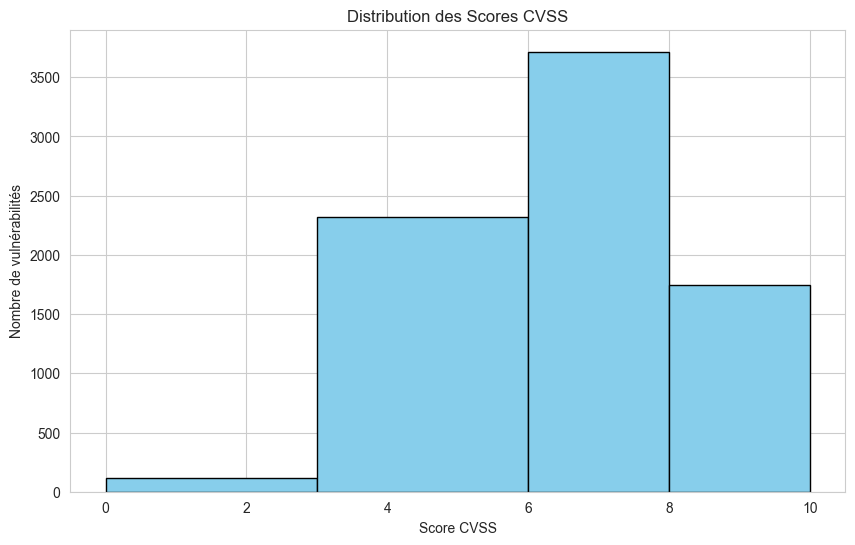

In [4]:
plt.figure(figsize=(10, 6))
df['cvss'].hist(bins=[0, 3, 6, 8, 10], edgecolor='black', color='skyblue')
plt.title("Distribution des Scores CVSS")
plt.xlabel("Score CVSS")
plt.ylabel("Nombre de vulnérabilités")
plt.grid(True)
plt.show()

## Répartition des types CWE (Top 10)

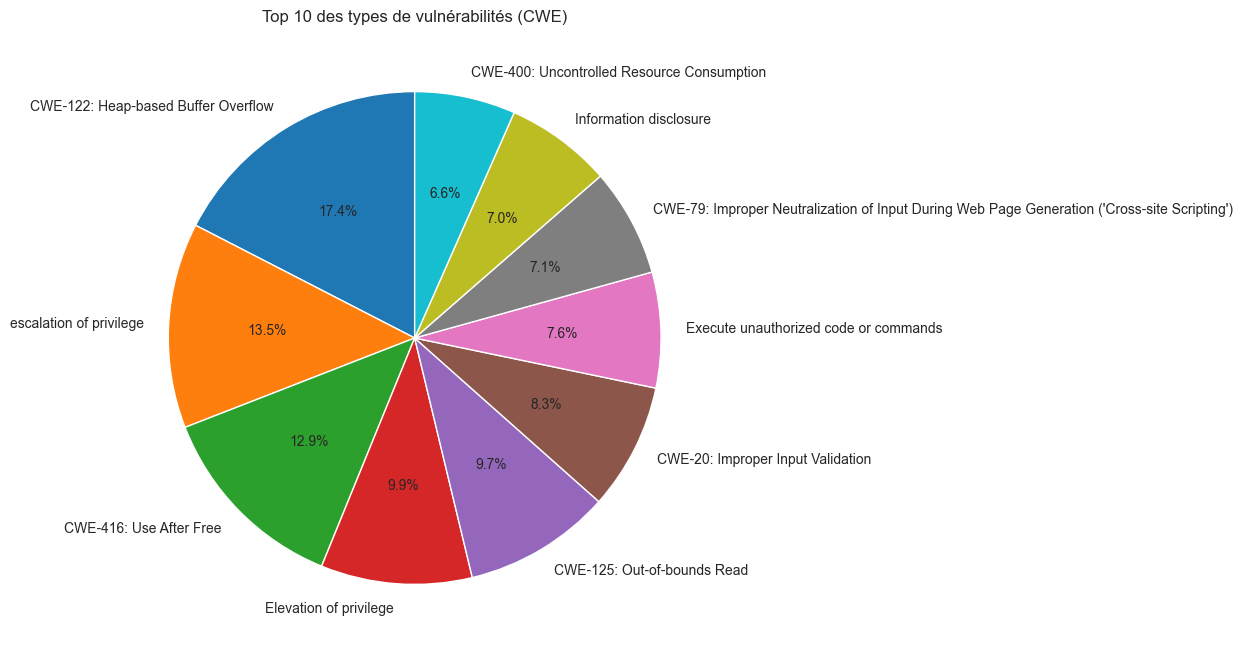

In [5]:
cwe_counts = df['cwe'].value_counts().head(10)
plt.figure(figsize=(8, 8))
cwe_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("Top 10 des types de vulnérabilités (CWE)")
plt.ylabel("")
plt.show()

## Courbe des scores EPSS

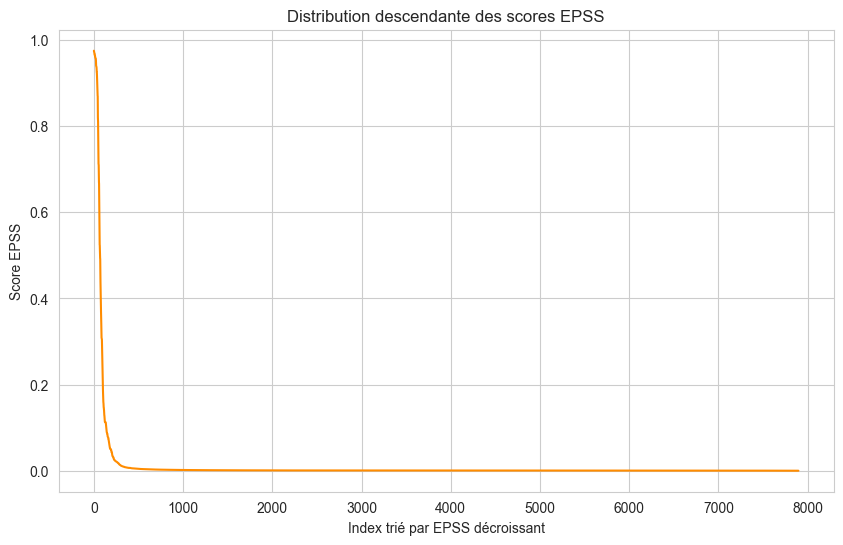

In [6]:
df_sorted = df.sort_values(by='epss', ascending=False).reset_index()
plt.figure(figsize=(10, 6))
plt.plot(df_sorted.index, df_sorted['epss'], color='darkorange')
plt.title("Distribution descendante des scores EPSS")
plt.xlabel("Index trié par EPSS décroissant")
plt.ylabel("Score EPSS")
plt.grid(True)
plt.show()

## Top 10 des éditeurs les plus cités

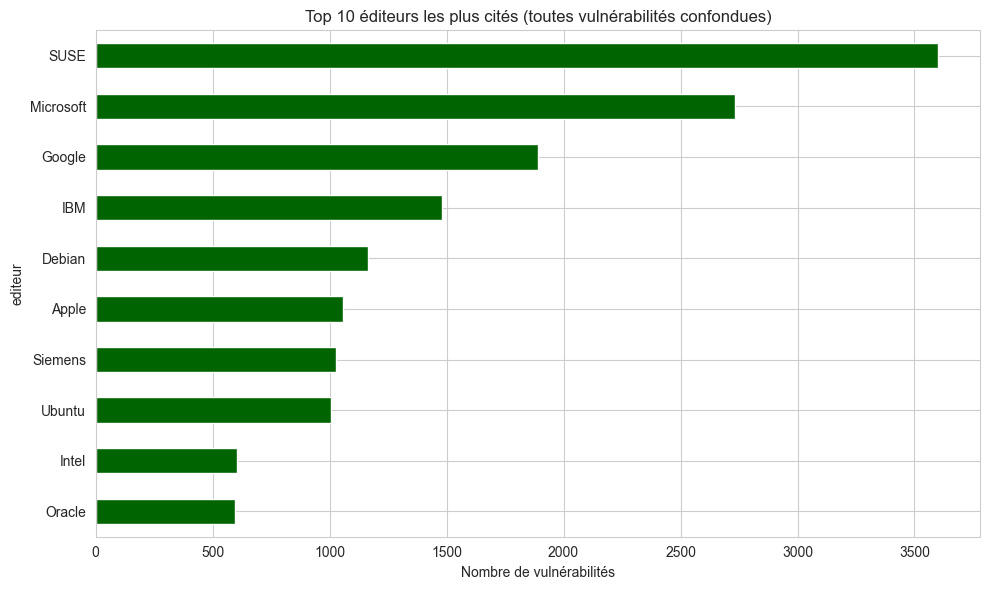

In [7]:
df_editors = df_all[df_all['editeur'].notna() & (df_all['editeur'] != "Non disponible")]
top_editors = df_editors['editeur'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_editors.plot(kind='barh', color='darkgreen')
plt.title("Top 10 éditeurs les plus cités (toutes vulnérabilités confondues)")
plt.xlabel("Nombre de vulnérabilités")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Corrélation CVSS vs EPSS

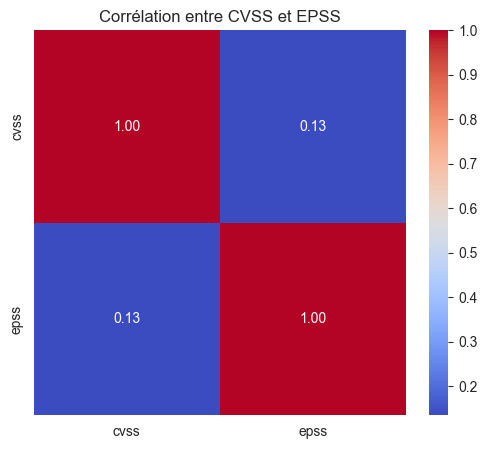

In [6]:
plt.figure(figsize=(6, 5))
sns.heatmap(df[['cvss', 'epss']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Corrélation entre CVSS et EPSS")
plt.show()

## Nuage de points : CVSS vs EPSS

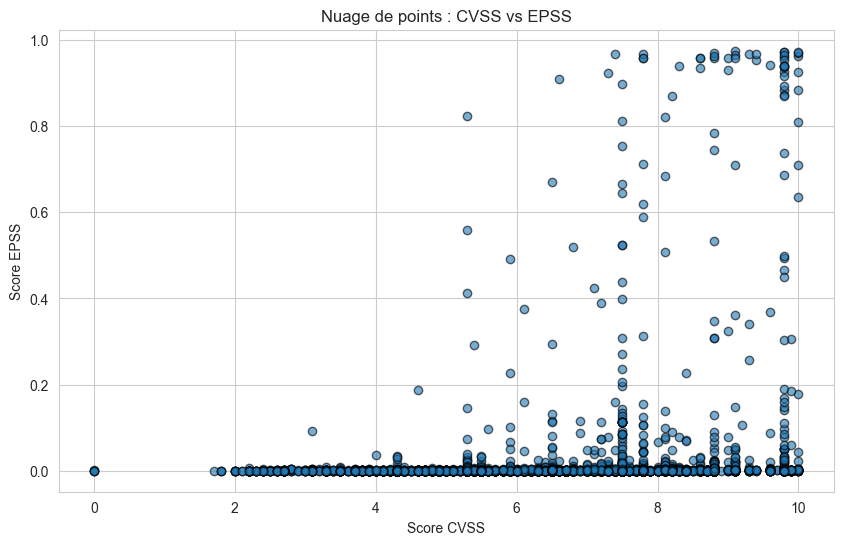

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(df['cvss'], df['epss'], alpha=0.6, edgecolors='k')
plt.title("Nuage de points : CVSS vs EPSS")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.grid(True)
plt.show()

## Évolution temporelle des vulnérabilités

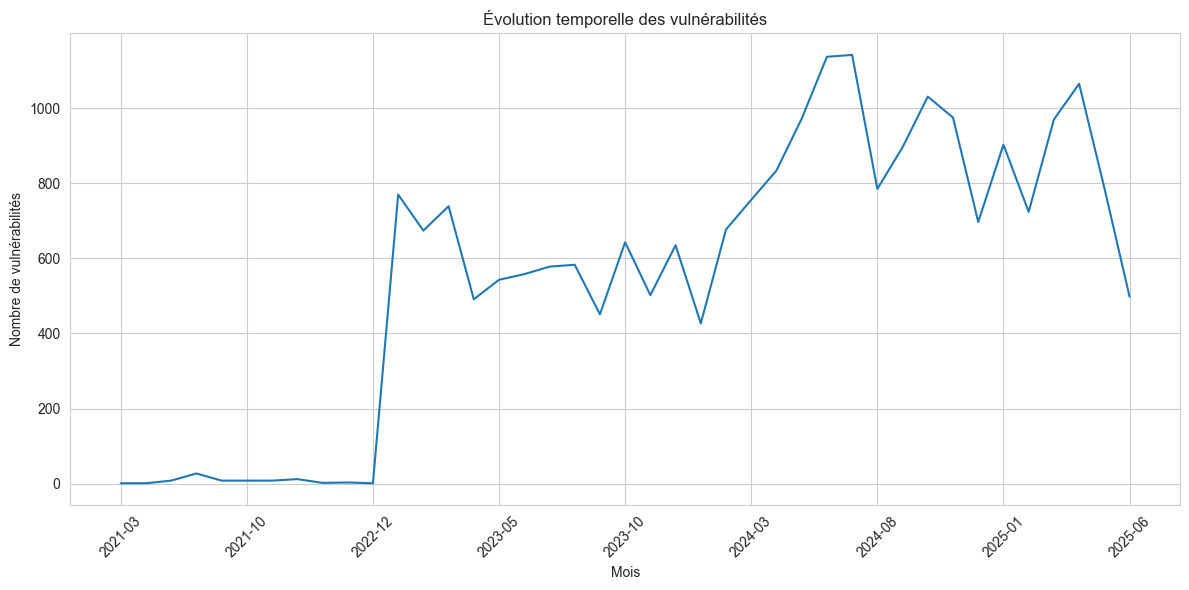

In [8]:
df_all['mois'] = df_all['date'].dt.to_period("M")
vulns_by_month = df_all.groupby('mois').size()
vulns_by_month.index = vulns_by_month.index.astype(str)
plt.figure(figsize=(12, 6))
vulns_by_month.plot()
plt.title("Évolution temporelle des vulnérabilités")
plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Boxplot des scores CVSS par éditeur (Top 5)

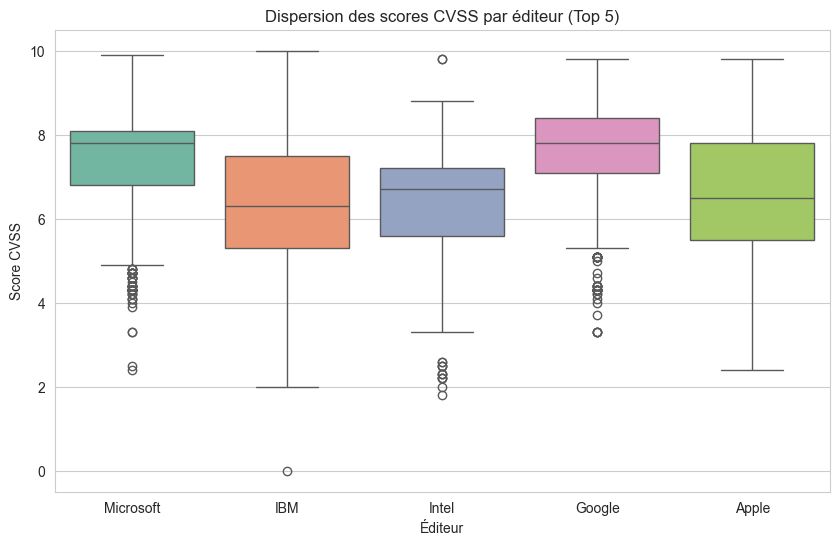

In [9]:
top5_editors = df['editeur'].value_counts().head(5).index
df_top5 = df[df['editeur'].isin(top5_editors)]
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_top5, x='editeur', y='cvss', hue='editeur', palette='Set2', legend=False)
plt.title("Dispersion des scores CVSS par éditeur (Top 5)")
plt.xlabel("Éditeur")
plt.ylabel("Score CVSS")
plt.show()

# Étape 7 – Machine Learning : Classification & Clustering

## Préparation des données

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("cve_ansi_enriched_save.csv")
df = df[df['cvss'].notna() & (df['cvss'] != "Non disponible")]
df = df[df['epss'].notna() & (df['epss'] != "Non disponible")]
df = df[~df['cwe'].str.contains("Non disponible", na=False)]
df = df[df['base severity'].notna()]
df['cvss'] = df['cvss'].astype(float)
df['epss'] = df['epss'].astype(float)

severity_mapping = {'LOW': 0, 'MEDIUM': 1, 'HIGH': 2, 'CRITICAL': 3}
valid_severities = set(severity_mapping.keys())
df = df[df['base severity'].str.upper().isin(valid_severities)]
df['severity_encoded'] = df['base severity'].str.upper().map(severity_mapping)

features = df[['cvss', 'epss']]
target = df['severity_encoded']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Classification supervisée avec Random Forest


Classification Report :
              precision    recall  f1-score   support

         LOW       1.00      1.00      1.00         1
      MEDIUM       1.00      0.97      0.98        33
        HIGH       0.97      1.00      0.99        33
    CRITICAL       1.00      1.00      1.00         8

    accuracy                           0.99        75
   macro avg       0.99      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75



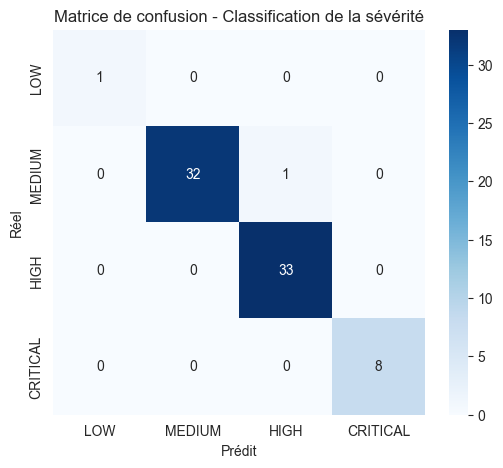

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print("Classification Report :")
print(classification_report(y_test, y_pred, target_names=severity_mapping.keys()))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=severity_mapping.keys(), yticklabels=severity_mapping.keys(), cmap="Blues")
plt.title("Matrice de confusion - Classification de la sévérité")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

## Clustering non supervisé avec KMeans + PCA


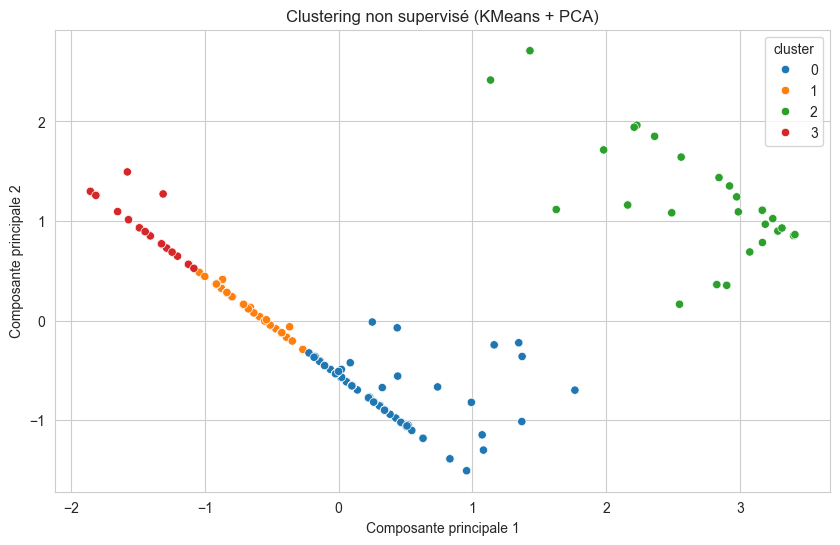

In [23]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

X_scaled = scaler.fit_transform(df[['cvss', 'epss']])
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df['pca1'] = pca_result[:, 0]
df['pca2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='tab10')
plt.title("Clustering non supervisé (KMeans + PCA)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid(True)
plt.show()

## Importance des variables

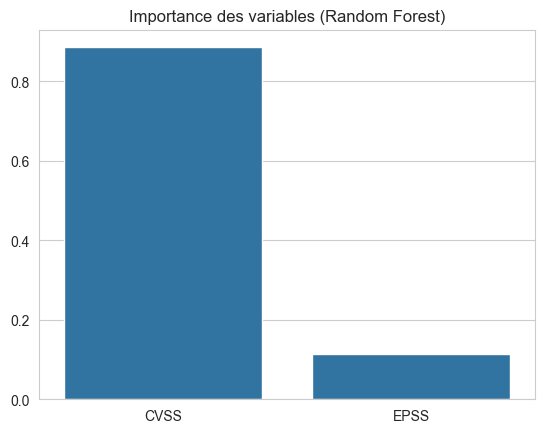

In [24]:
importances = clf.feature_importances_
sns.barplot(x=['CVSS', 'EPSS'], y=importances)
plt.title("Importance des variables (Random Forest)")
plt.show()